In [27]:
%load_ext autoreload
%autoreload 2

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from spectrum import Spectrum

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


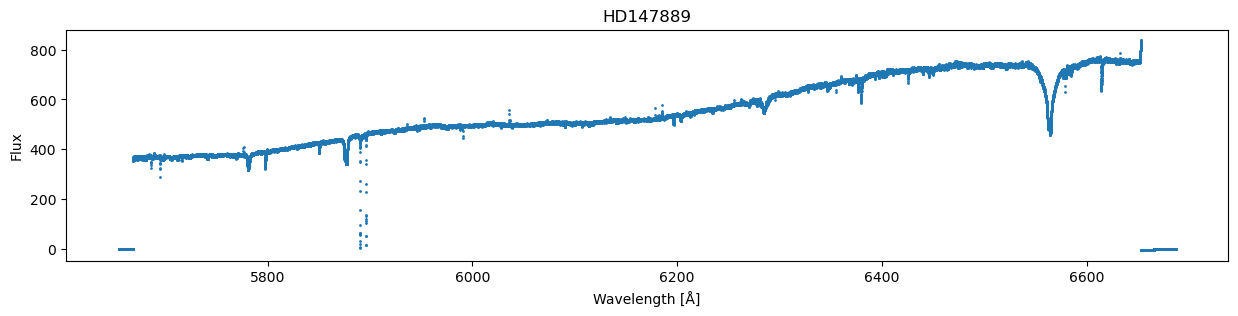

In [29]:
def load_spectrum(datafile):
    wvl, flux = np.loadtxt(f'data/DR4/{datafile}', usecols=(0, 3), unpack=True, skiprows=1)
    target_name = datafile.split('_')[0]

    return Spectrum(target_name, wvl, flux)

hd147889 = load_spectrum('HD147889_w564_n1_20140927_U.ascii')
hd170740 = load_spectrum('HD170740_w564_n2_20160505_U.ascii')
hd185859 = load_spectrum('HD185859_w564_n8_20160813_U.ascii')
hd151804 = load_spectrum('HD151804_w564_n9_20160510_U.ascii')
# hd158926 = load_spectrum('HD158926') # No data!!

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))
hd147889.plot(ax)

Training on 3 spectra: HD170740, HD185859, HD151804:   0%|          | 0/4 [00:00<?, ?it/s]

Training on 3 spectra: HD147889, HD170740, HD185859: 100%|██████████| 4/4 [02:28<00:00, 37.01s/it]


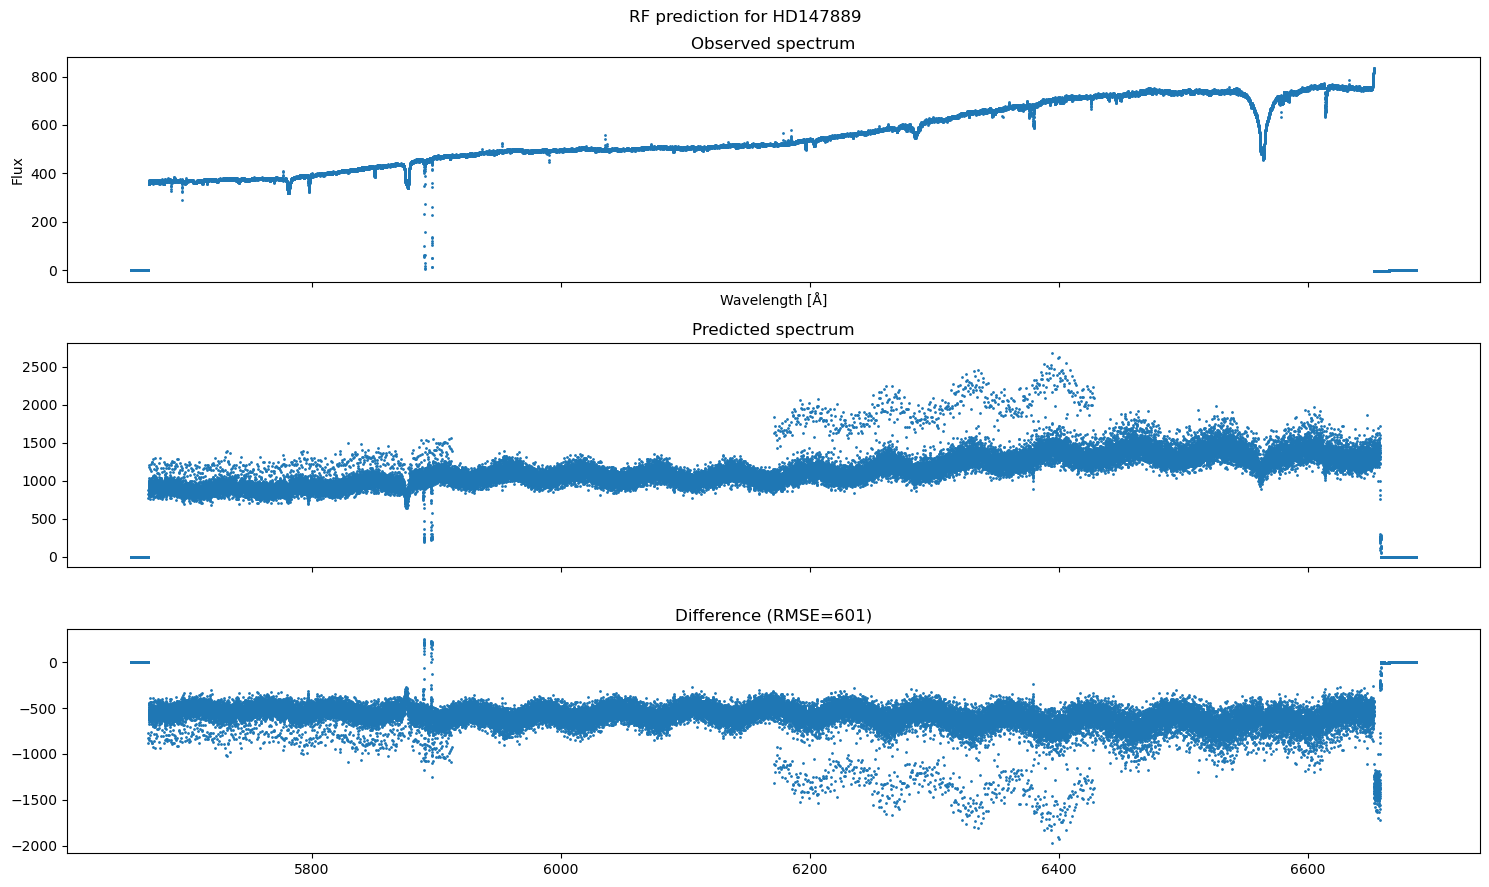

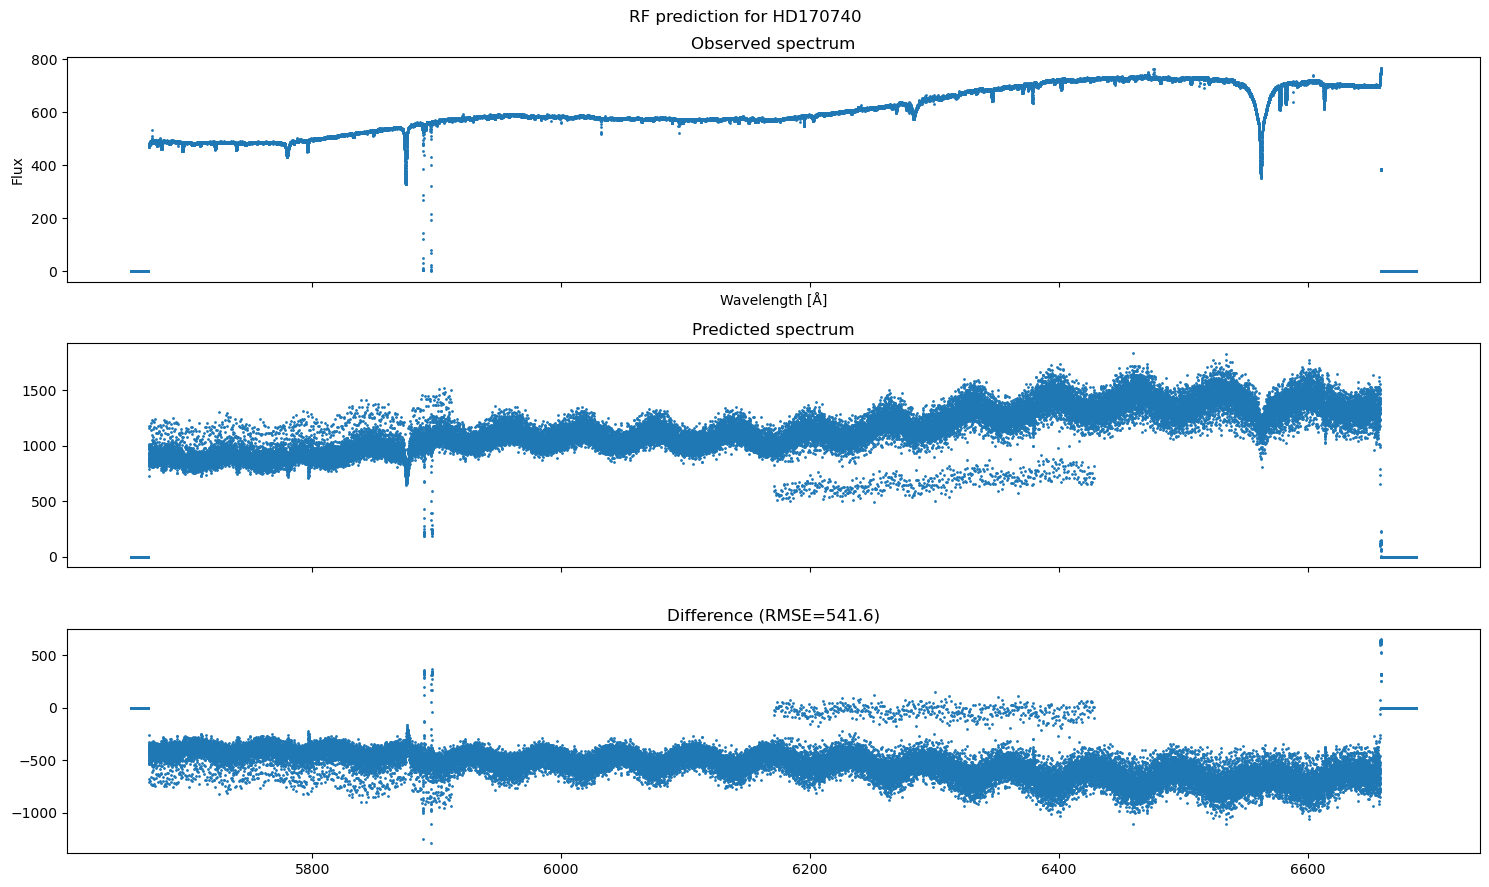

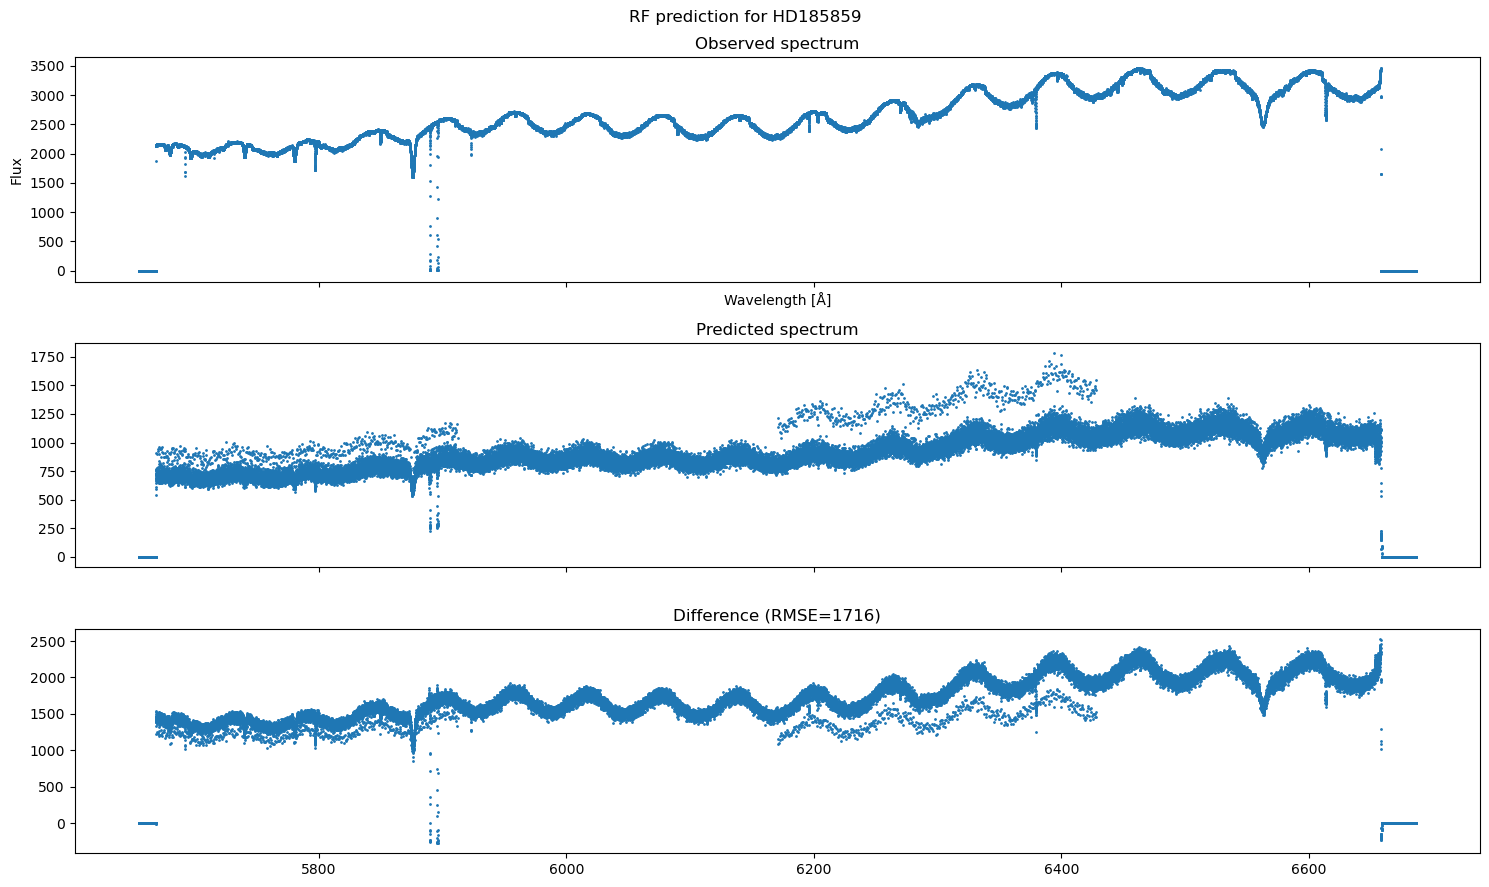

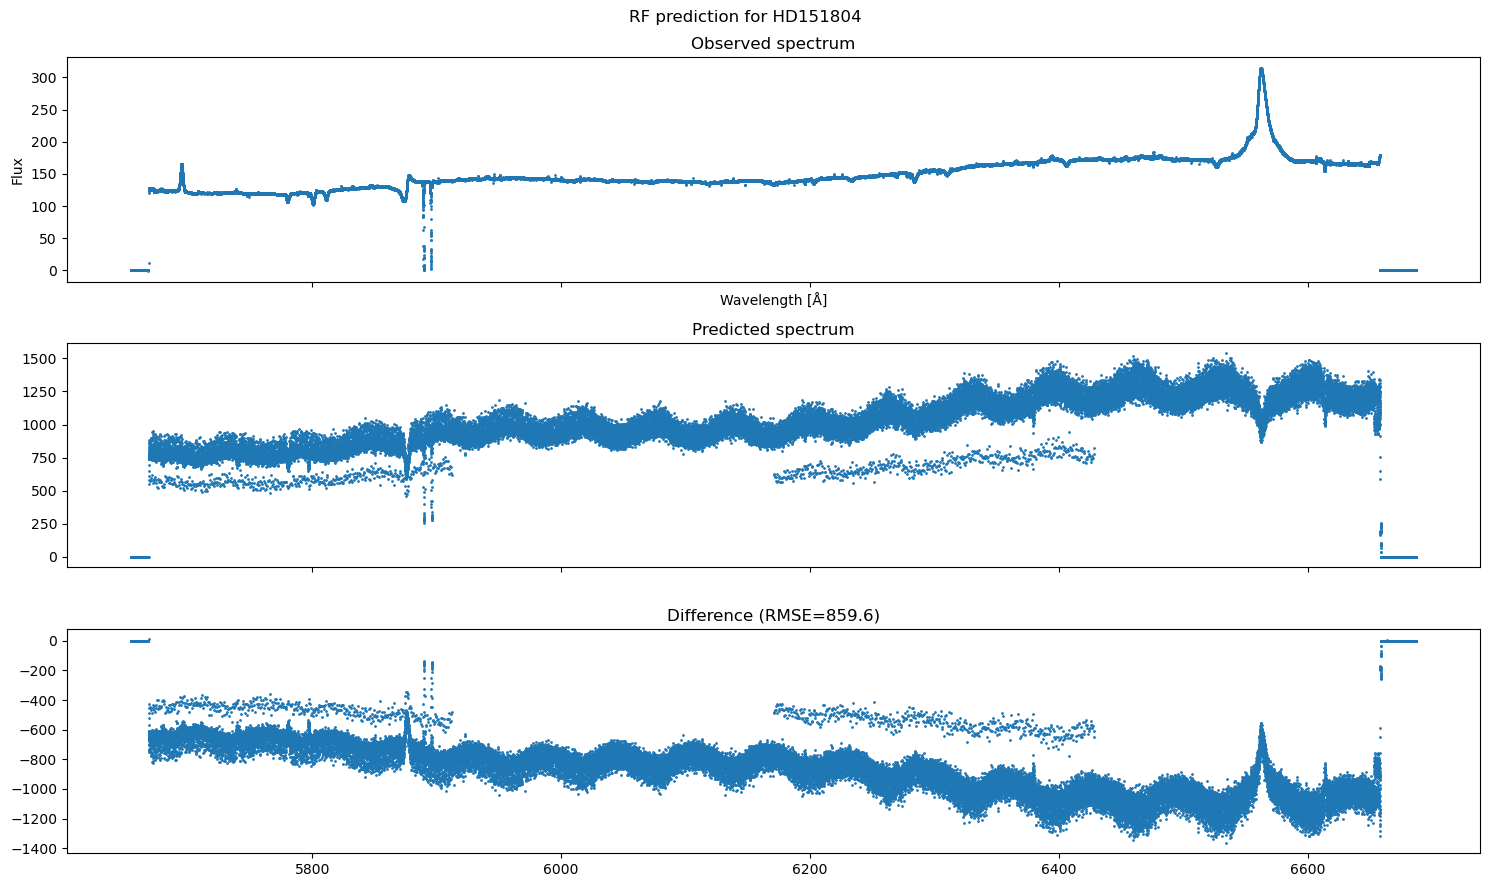

In [35]:
def train_rf(rf: RandomForestRegressor, spectra: list[Spectrum]) -> RandomForestRegressor:
    wavelength = np.concatenate([spectrum.wavelength for spectrum in spectra])[:, np.newaxis]
    flux = np.concatenate([spectrum.flux for spectrum in spectra])

    rf.fit(wavelength, flux)

def plot_rf_prediction(rf: RandomForestRegressor, test_spectrum: Spectrum):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 9), sharex=True)

    predicted_flux = rf.predict(test_spectrum.wavelength[:, np.newaxis])
    rmse = root_mean_squared_error(test_spectrum.flux, predicted_flux)

    test_spectrum.plot(axes[0])
    axes[1].plot(test_spectrum.wavelength, predicted_flux, '.', ms=2)
    axes[2].plot(test_spectrum.wavelength, test_spectrum.flux - predicted_flux, '.', ms=2)

    axes[0].set_title('Observed spectrum')
    axes[1].set_title('Predicted spectrum')
    axes[2].set_title(f'Difference (RMSE={rmse:.4g})')

    fig.suptitle(f'RF prediction for {test_spectrum.target}')
    fig.tight_layout()


def cross_validation(spectra: list[Spectrum], n_estimators=100):
    # Start with 0 estimators because it gets increased in the for-loop straightaway
    rf = RandomForestRegressor(n_estimators=0, warm_start=True, random_state=27)
    spectra_tqdm = tqdm(spectra)

    for spectrum in spectra_tqdm:
        training_spectra = [spec for spec in spectra if spec is not spectrum]
        rf.n_estimators += n_estimators

        spectra_tqdm.set_description(f'Training on {len(training_spectra)} spectra: {', '.join([ts.target for ts in training_spectra])}')
        train_rf(rf, training_spectra)
        plot_rf_prediction(rf, spectrum)

cross_validation([hd147889, hd170740, hd185859, hd151804])